## RQ2: How ensemble learning techniques perform in predicting security vulnerbilities?
## Deliverables
1. Confusion matrix for stacking classifier = 1 CM.
2. Performance metrics (Accuracy, Precision and Recall) for stacking classifier = 1 row
3. AUC-ROC curve for stacking classifier x 1 combined graph = 1 AUC-ROC graph.

## Learners
1. Stacking classifier (DT, LR, NB, XGB)

##Datasets
1. Apache Tomcat
2. Apache Struts2-core

### Prerequisites

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import sys

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE

# Handling imbalance data
from imblearn.over_sampling  import RandomOverSampler

# CV
from sklearn.model_selection import RepeatedStratifiedKFold

# Performance metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from numpy import mean, std
from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import roc_curve

#ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# Ensemble techniques
from sklearn.ensemble import StackingClassifier

def preprocess(dataset_idx, target, version=None):
    ds = ["./datasets/tomcat-final.csv", "./datasets/struts-final.csv"]
    df = pd.read_csv(ds[dataset_idx])
    np.set_printoptions(threshold=np.inf)
    pd.set_option('max_columns', None)
    print(f"Dataframe {ds[dataset_idx][-16:]} created..\nTotal number of rows: ", df.shape[0])
    df = cleanup(df)
    return split_features_variables(df, target, version)

def cleanup(df):
    df.loc[df['title'].str.contains('Denial', case=False), 'title'] = 'DoS'
    df.loc[df['title'].str.contains('CSRF', case=False), 'title'] = 'CSRF'
    df.loc[df['title'].str.contains(
        'information disclosure', case=False), 'title'] = 'Information Disclosure'
    df.loc[df['title'].str.contains(
        'cve-2020-9484', case=False), 'title'] = 'Remote Code execution'
    df.loc[df['title'].str.contains(
        'session hijacking', case=False), 'title'] = 'Remote Code execution'
    df = df.drop_duplicates(keep='first').reset_index(drop=True)
    return df

def split_features_variables(df, target, version):
    y_cols = ['vulnerable', 'severity', 'title']
    feature_columns = df.columns[2:-4]
    if version:
        train = df.loc[~(df.version == version)]
        test = df.loc[df.version == version]
    else:
        train, test = train_test_split(df, shuffle=True,test_size=0.3)
    X = train[feature_columns]
    test_X = test[feature_columns]
    if y_cols[target] == 'vulnerable':
        y = train[y_cols[target]]
        test_Y = test[y_cols[target]]
    else: 
        label_X_train, label_X_test = label_encode(train, test)
        y = label_X_train[y_cols[target]]
        test_Y = label_X_test[y_cols[target]]
    return X, test_X, y, test_Y  


def label_encode(train, test):
    print('Labelled target found..')
    s = (train.dtypes == 'object')
    object_cols = ['severity', 'title']
    label_X_train = train.copy()
    label_X_test = test.copy()
    le = LabelEncoder()
    label_X_train[object_cols] = train[object_cols].apply(le.fit_transform)
    label_X_test[object_cols] = test[object_cols].apply(le.fit_transform)
    print('Encoded...')
    return label_X_train, label_X_test

def fit_feature_set(feature_set):
    global X_ros
    X_ros = X_ros[feature_set]
    global test_X
    test_X = test_X[feature_set]

def evaluate(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
    return cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1), cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1), cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)

def stacking():
    level0 = list()
    level0.append(('lr', LogisticRegression(solver='saga',class_weight='balanced', max_iter=4000)))
    level0.append(('dt', DecisionTreeClassifier(ccp_alpha=0.036)))
    level0.append(('nb', GaussianNB()))
    level1 = xgb.XGBClassifier()
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

def predict(model):
    model.fit(X_ros, y_ros)
    predictions = model.predict(test_X)
    pred_proba = model.predict_proba(test_X)
    accuracy = accuracy_score(test_Y, predictions)
    precision = precision_score(test_Y, predictions, average='weighted')
    recall = recall_score(test_Y, predictions,average='weighted')
    return [accuracy, precision, recall, pred_proba ,predictions]

def get_models():
    models = dict()
    models['Decision Tree'] = DecisionTreeClassifier(ccp_alpha=0.036)
    models['Logistic Regression'] = LogisticRegression(solver='liblinear', class_weight='balanced')
    models['Naive Bayes'] = GaussianNB()
    models['Stacking'] = stacking()
    return models

### Experiments

In [7]:
ds = 1
target = 2
targets = ['Vulnerable','Severity','Title']
datasets = ['Tomcat','Struts']
X, test_X, y, test_Y = preprocess(ds, target)
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

Dataframe struts-final.csv created..
Total number of rows:  19372
Labelled target found..
Encoded...


### Feature selection

In [8]:
rfe = RFE(estimator=DecisionTreeClassifier())
rfe.fit(X_ros, y_ros)
rfe_features = []
for i in range(X.shape[1]):
    if(rfe.support_[i] == 1):
        rfe_features.append(X.columns[i])
fit_feature_set(rfe_features)

### Stacking classifier

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

Accuracy: 0.997 (0.000)
Precision: 0.997 (0.000) 

Recall: 0.997 (0.000)


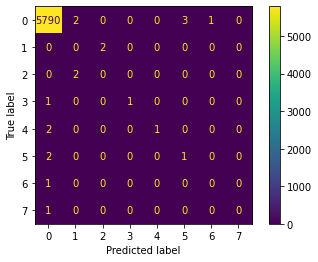

In [9]:
model = get_models()['Stacking']
pred_model = predict(model)
acc, pre, rec ,stk_pred = pred_model[0], pred_model[1], pred_model[2], pred_model[-2]
print('Accuracy: %.3f (%.3f)' % (mean(acc), std(acc)))
print('Precision: %.3f (%.3f) \n' % (mean(pre), std(pre)))
print('Recall: %.3f (%.3f)' % (mean(rec), std(rec)))
CMD.from_estimator(model, test_X, test_Y)

### AUC-ROC curve

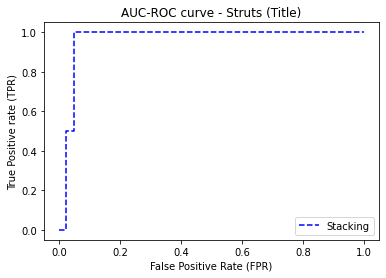

In [10]:
# roc curve for models
fpr = {}
tpr = {}
thresh ={}
    
fpr1, tpr1, thresh1 = roc_curve(test_Y, stk_pred[:,1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_Y))]
p_fpr, p_tpr, _ = roc_curve(test_Y, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--', color='blue', label='Stacking')

# title
plt.title('AUC-ROC curve - '+datasets[ds]+' ('+targets[target]+')')
# x label
plt.xlabel('False Positive Rate (FPR)')
# y label
plt.ylabel('True Positive rate (TPR)')

plt.legend(loc='best')
plt.show();